In [89]:
import os
import sys
import copy
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm
from numpy.fft import fft, ifft
from scipy.signal import correlate2d


# Get current working directory and project root directory
cwd = os.getcwd()
rd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0])
if not rd.endswith('stochastic-travel-demand-modelling'):
    rd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0],'stochastic-travel-demand-modelling')

if rd not in sys.path:
    sys.path.append(rd)

# from models.singly_constrained.spatial_interaction_model import SpatialInteraction

# Import data

In [90]:
dataset = 'commuter_ward'
constrained = 'singly'

In [91]:
# Import commuter Borough to Borough data
cost_matrix = np.loadtxt(os.path.join(rd,f'data/input/{dataset}/cost_matrix.txt'))
origin_supply = np.loadtxt(os.path.join(rd,f'./data/input/{dataset}/origin_supply.txt'))
initial_destination_sizes = np.loadtxt(os.path.join(rd,f'./data/input/{dataset}/initial_destination_sizes.txt'))

o = origin_supply/np.sum(origin_supply)
c = cost_matrix/np.sum(cost_matrix)
xd = np.log(initial_destination_sizes/np.sum(initial_destination_sizes))

orig_locs = np.loadtxt(os.path.join(rd,f'./data/input/{dataset}/origin_locations.txt'))
dest_locs = np.loadtxt(os.path.join(rd,f'./data/input/{dataset}/destination_locations.txt'))

N,M = cost_matrix.shape

alpha = 1.2
beta = 1400
delta = np.min(np.exp(xd))
gamma = 100
kappa = 1 + delta*M
epsilon = 1
theta = np.array([alpha,beta,delta,gamma,kappa,epsilon])

In [92]:
np.sum(initial_destination_sizes)

4581000.0

In [93]:
np.sum(cost_matrix)

9171.228658308206

In [94]:
np.sum(initial_destination_sizes)

4581000.0

In [95]:
np.min(np.exp(xd))

0.01178781925343811

In [96]:
np.min(cost_matrix)

0.03624043372875424

In [97]:
np.max(cost_matrix)

0.8476181560889813

true_beta 35630.56305630563
min cost contribution 0.037141217816547833
max cost contribution 0.868666998947804


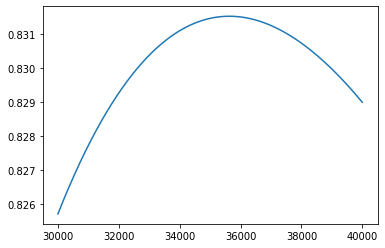

In [98]:
trials = np.linspace(30000,40000,10000)
y = [np.max(np.exp(-c*x))-np.min(np.exp(-c*x)) for x in trials]

plt.plot(trials,y)

true_beta = trials[np.argmax(y)]
print('true_beta',true_beta)

print('min cost contribution',np.min(np.exp(-c*true_beta)))
print('max cost contribution',np.max(np.exp(-c*true_beta)))

# Visualise destination sizes

In [99]:
# Set plot params
latent_factor = 1000
actual_factor = 10000

In [100]:
xdhat = np.array([-5.1897801 , -5.23642623, -5.4009969 , -5.12936143, -5.45127185,
       -4.52849762, -4.34934874, -5.31418112, -5.21250051, -5.41850884,
       -5.18537558, -4.63007369, -4.76650644, -4.87568667, -5.34561429,
       -5.51060864, -5.67272346, -5.51273392, -4.65328199, -4.36501201,
       -5.61081968, -4.70222637, -4.93021163, -5.27901482, -4.84244201,
       -5.43335431, -5.18788226, -4.43311806, -5.30968679, -4.66790956,
       -5.16315853, -4.78427364, -4.39252913])

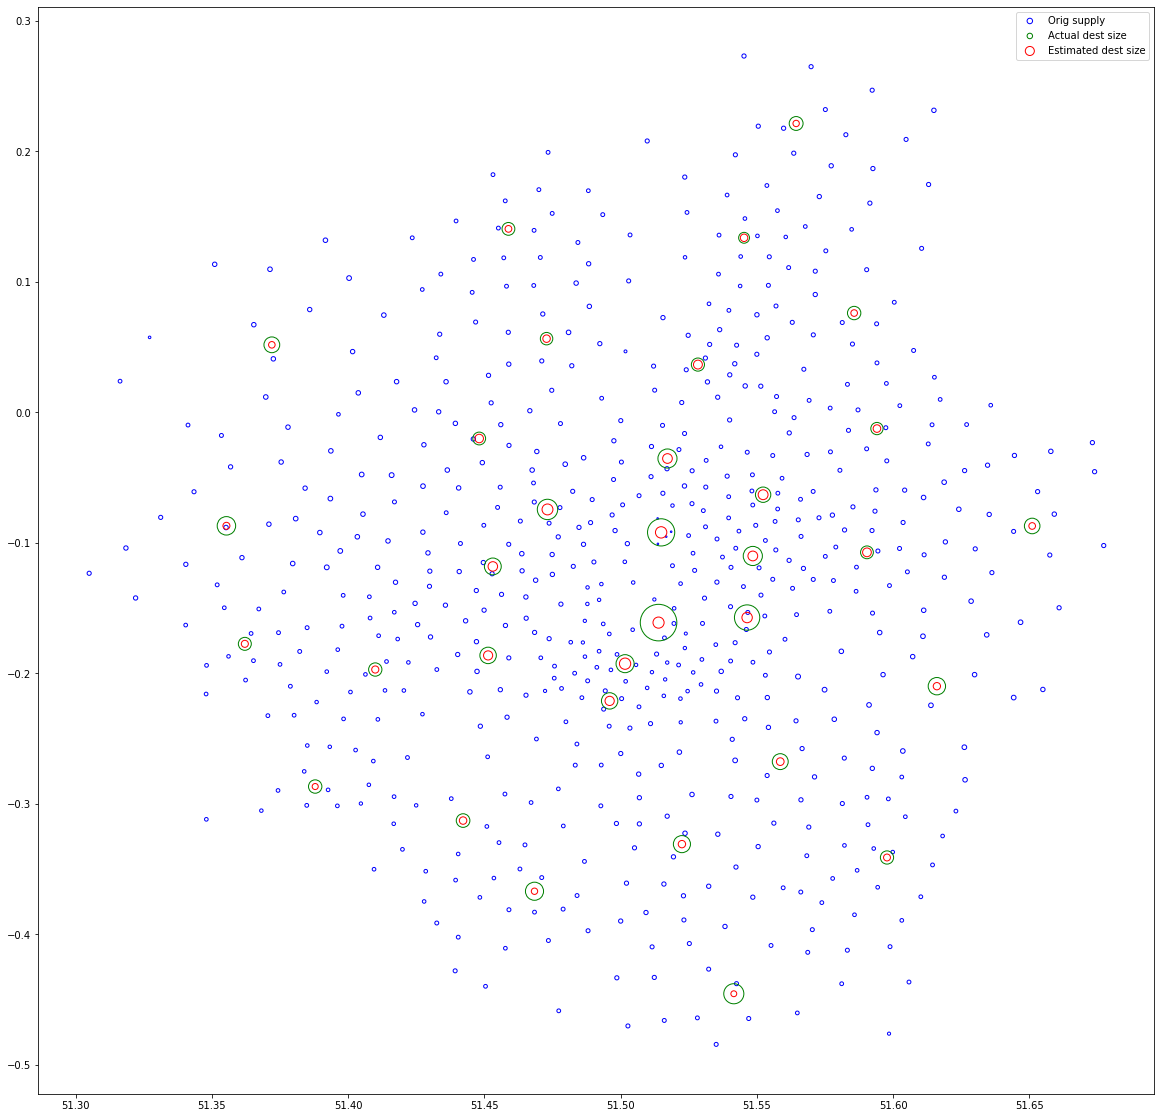

In [101]:
plt.figure(figsize=(20,20))
plt.scatter(orig_locs[:, 1], orig_locs[:, 0], facecolor="None",edgecolors='b', s=actual_factor*o, alpha=1,label='Orig supply')
plt.scatter(dest_locs[:, 1], dest_locs[:, 0], facecolor="None",edgecolors='g', s=actual_factor*np.exp(xd), alpha=1,label='Actual dest size')
plt.scatter(dest_locs[:, 1], dest_locs[:, 0], facecolor="None",edgecolors='r', s=actual_factor*np.exp(xdhat), alpha=1,label='Estimated dest size')
# Plot legend.
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

# Check convexity

In [102]:
def is_pos_semidef(M):
    return np.all(np.linalg.eigvals(M) >= 0)

def convexity_test(M):
    
    if is_pos_semidef(M):
        print('Potential function is convex.')
        return True
    else:
        print(f'alpha = {theta[0]}')
        print('Potential function is NOT convex.')
        return False

In [103]:
# si = SpatialInteraction(dataset)
# si.normalise_data()

# # Get destination sizes
# xd = si.normalised_initial_destination_sizes

# theta[0] = 1.01
# theta[1] = 0.04

# # Get hessian
# hessian = si.potential_hessian(xd,theta)

# # Run convexity test
# convexity_test(hessian)

# MCMC samples

## Low noise

In [104]:
samples = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_low_noise_theta_samples.txt"))
samples2 = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_low_noise_logsize_samples.txt"))
samples3 = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_low_noise_sign_samples.txt"))

In [105]:
np.mean(samples,axis=0)

array([1.13957411, 0.03009477])

In [106]:
np.std(samples,axis=0)

array([0.00271504, 0.00321682])

In [107]:
posterior_xd = np.mean(samples2,axis=0)

In [108]:
np.exp(posterior_xd)

array([0.01515872, 0.0274368 , 0.01784149, 0.02565678, 0.02251445,
       0.05273118, 0.06476314, 0.02841336, 0.02588709, 0.02385684,
       0.01928689, 0.02793898, 0.02943884, 0.02167044, 0.01865888,
       0.01772353, 0.02501418, 0.02553981, 0.03767208, 0.03435076,
       0.0192953 , 0.03251438, 0.02135859, 0.02150892, 0.0212856 ,
       0.01987251, 0.02019902, 0.04147033, 0.01957882, 0.03695047,
       0.01941912, 0.02953445, 0.12428031])

In [109]:
np.exp(xd)

array([0.01178782, 0.03012443, 0.01637197, 0.02532198, 0.0248854 ,
       0.06417813, 0.07400131, 0.0340537 , 0.02925126, 0.02423052,
       0.0154988 , 0.02357564, 0.02685003, 0.01637197, 0.01746344,
       0.01920978, 0.0403842 , 0.03274394, 0.03667322, 0.03252565,
       0.01790002, 0.02837808, 0.01637197, 0.01768173, 0.01724514,
       0.01790002, 0.0185549 , 0.04147566, 0.01680856, 0.03645492,
       0.01506221, 0.02706833, 0.13359528])

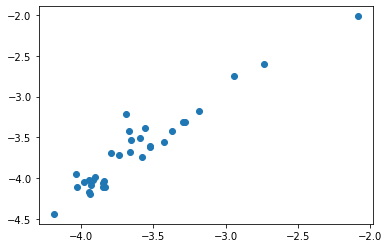

In [110]:
plt.scatter(posterior_xd,xd)

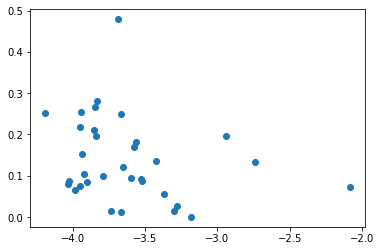

In [111]:
plt.scatter(posterior_xd,abs(xd-posterior_xd))

In [112]:
np.corrcoef(posterior_xd,xd)[0,1]

0.9524641410261723

(array([[    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 20000.],
        [20000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]]),
 array([0.02052122, 0.13307756, 0.24563389, 0.35819022, 0.47074656,
        0.58330289, 0.69585922, 0.80841556, 0.92097189, 1.03352822,
        1.14608456]),
 <a list of 2 Lists of Patches objects>)

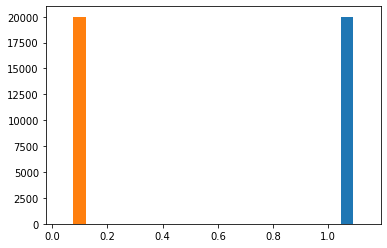

In [113]:
plt.hist(samples)

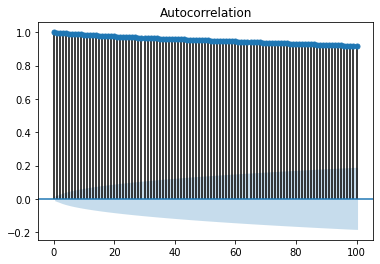

In [114]:
sm.graphics.tsa.plot_acf(samples[:,0], lags=100)
plt.show()

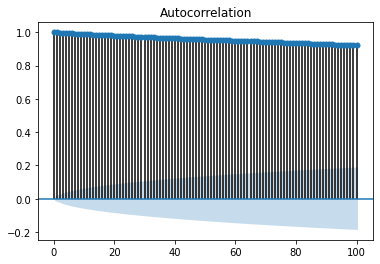

In [115]:
sm.graphics.tsa.plot_acf(samples[:,1], lags=100)
plt.show()

In [116]:
print(np.mean(samples[::1500],axis=0))
print(np.std(samples[::1500],axis=0))

[1.13999042 0.02909522]
[0.00265667 0.00397216]


## High noise

In [117]:
high_samples = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_high_noise_theta_samples.txt"))
high_samples2 = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_high_noise_logsize_samples.txt"))
high_samples3 = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_high_noise_sign_samples.txt"))

In [118]:
np.mean(high_samples,axis=0)

array([ 2.01433310e+292, -3.95006961e+301])

In [106]:
np.std(high_samples,axis=0)

array([0.00271504, 0.00321682])

In [107]:
posterior_xd = np.mean(high_samples2,axis=0)

In [108]:
np.exp(posterior_xd)

array([0.01515872, 0.0274368 , 0.01784149, 0.02565678, 0.02251445,
       0.05273118, 0.06476314, 0.02841336, 0.02588709, 0.02385684,
       0.01928689, 0.02793898, 0.02943884, 0.02167044, 0.01865888,
       0.01772353, 0.02501418, 0.02553981, 0.03767208, 0.03435076,
       0.0192953 , 0.03251438, 0.02135859, 0.02150892, 0.0212856 ,
       0.01987251, 0.02019902, 0.04147033, 0.01957882, 0.03695047,
       0.01941912, 0.02953445, 0.12428031])

In [109]:
np.exp(xd)

array([0.01178782, 0.03012443, 0.01637197, 0.02532198, 0.0248854 ,
       0.06417813, 0.07400131, 0.0340537 , 0.02925126, 0.02423052,
       0.0154988 , 0.02357564, 0.02685003, 0.01637197, 0.01746344,
       0.01920978, 0.0403842 , 0.03274394, 0.03667322, 0.03252565,
       0.01790002, 0.02837808, 0.01637197, 0.01768173, 0.01724514,
       0.01790002, 0.0185549 , 0.04147566, 0.01680856, 0.03645492,
       0.01506221, 0.02706833, 0.13359528])

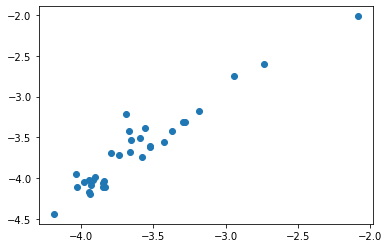

In [110]:
plt.scatter(posterior_xd,xd)

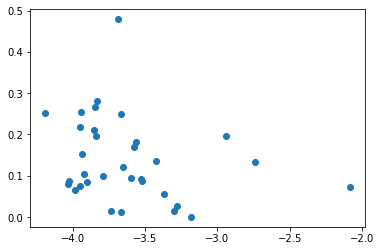

In [111]:
plt.scatter(posterior_xd,abs(xd-posterior_xd))

In [112]:
np.corrcoef(posterior_xd,xd)[0,1]

0.9524641410261723

(array([[    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 20000.],
        [20000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]]),
 array([0.02052122, 0.13307756, 0.24563389, 0.35819022, 0.47074656,
        0.58330289, 0.69585922, 0.80841556, 0.92097189, 1.03352822,
        1.14608456]),
 <a list of 2 Lists of Patches objects>)

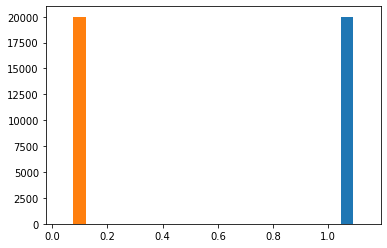

In [113]:
plt.hist(high_samples)

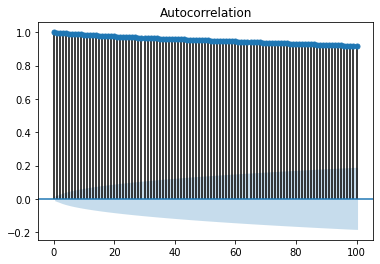

In [114]:
sm.graphics.tsa.plot_acf(high_samples[:,0], lags=100)
plt.show()

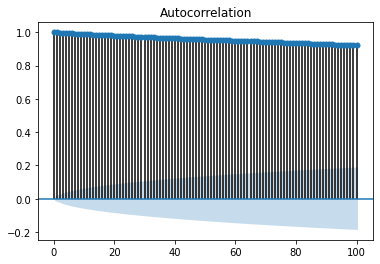

In [115]:
sm.graphics.tsa.plot_acf(samples[:,1], lags=100)
plt.show()

In [116]:
print(np.mean(high_samples[::1500],axis=0))
print(np.std(high_samples[::1500],axis=0))

[1.13999042 0.02909522]
[0.00265667 0.00397216]


# Compare population origin supply to borough commuter origin supply

In [72]:
# Import borough supply
origin_supply_borough = np.loadtxt(os.path.join(rd,f'./data/input/commuter_borough/origin_supply.txt'))
ob = origin_supply_borough/np.sum(origin_supply_borough)
boroughs = np.loadtxt(os.path.join(rd,f'./data/input/commuter_borough/origins.txt'),dtype=str)
wards = np.loadtxt(os.path.join(rd,f'./data/input/commuter_ward/origins.txt'),dtype=str)

# Create borough df
borough_df = pd.DataFrame(data=np.array([boroughs,ob]).T,columns=['borough','borough_origin'])

# Import ward to borough map
with open(os.path.join(rd,f'data/input/misc/ward_coordinates.json')) as infile:
    ward_coords = json.load(infile)

# Convert ward coordinates to dataframe
ward_properties = [x['properties'] for x in ward_coords['features']]
wards_df = pd.DataFrame.from_records(ward_properties)

# Sort wards_df
wards_df = wards_df.sort_values('ward_new')

# Add ward origin supply
wards_df['ward_origin'] = o

# Join ward to borough df
wards_df = wards_df[['ward_new','borough_new','ward_origin']]

# Get ward origin supply by borough
population_by_borough = wards_df.groupby('borough_new').sum().sort_values('borough_new')
ow = population_by_borough['ward_origin'].values

In [73]:
ow

array([0.02285861, 0.04385945, 0.0304384 , 0.03673461, 0.04120653,
       0.0276098 , 0.00100055, 0.04609353, 0.04196098, 0.03814215,
       0.02989407, 0.02827962, 0.02303958, 0.03018743, 0.02883594,
       0.03126689, 0.03388231, 0.02960657, 0.02451126, 0.02215797,
       0.02053404, 0.03711177, 0.03470703, 0.02619989, 0.03400556,
       0.03327272, 0.02402898, 0.03414151, 0.02506494, 0.02734293,
       0.03044314, 0.03630461, 0.02527659])

In [74]:
ob

array([0.02061388, 0.04234396, 0.03035825, 0.03624706, 0.04245229,
       0.02795389, 0.00131891, 0.04632537, 0.04320524, 0.03622633,
       0.02853237, 0.02494888, 0.02571578, 0.02978764, 0.02776869,
       0.03052593, 0.0329993 , 0.02965929, 0.02514731, 0.02215124,
       0.02049911, 0.04151056, 0.03645085, 0.02862568, 0.02714624,
       0.03205972, 0.02481338, 0.03425064, 0.02518735, 0.02331535,
       0.03070291, 0.04411478, 0.02704184])

In [75]:
np.corrcoef(ow,ob)

array([[1.        , 0.95987199],
       [0.95987199, 1.        ]])

In [76]:
ow/ob

array([1.10889393, 1.03579022, 1.00264019, 1.01345078, 0.97065522,
       0.98769084, 0.75861302, 0.99499553, 0.97120139, 1.05288494,
       1.04772493, 1.13350242, 0.89593193, 1.01342135, 1.03843362,
       1.02427317, 1.0267585 , 0.99822247, 0.97470712, 1.0003039 ,
       1.00170378, 0.89403201, 0.95215969, 0.91525826, 1.25268055,
       1.0378358 , 0.96838783, 0.99681378, 0.99513975, 1.17274401,
       0.99153947, 0.82295805, 0.9347215 ])

In [83]:
np.log(ow)/np.log(ob)

array([0.97337233, 0.98887874, 0.99924551, 0.99597241, 1.00942717,
       1.00346236, 1.04166275, 1.00163311, 1.00930087, 0.98446822,
       0.9868921 , 0.96604854, 1.03001948, 0.99620564, 0.98947682,
       0.99312639, 0.99225896, 1.00050572, 1.0069558 , 0.99992025,
       0.99956209, 1.03520442, 1.01480242, 1.02491916, 0.93753372,
       0.98920468, 1.00869031, 1.00094584, 1.00132343, 0.95760537,
       1.00243915, 1.06243272, 1.01869799])

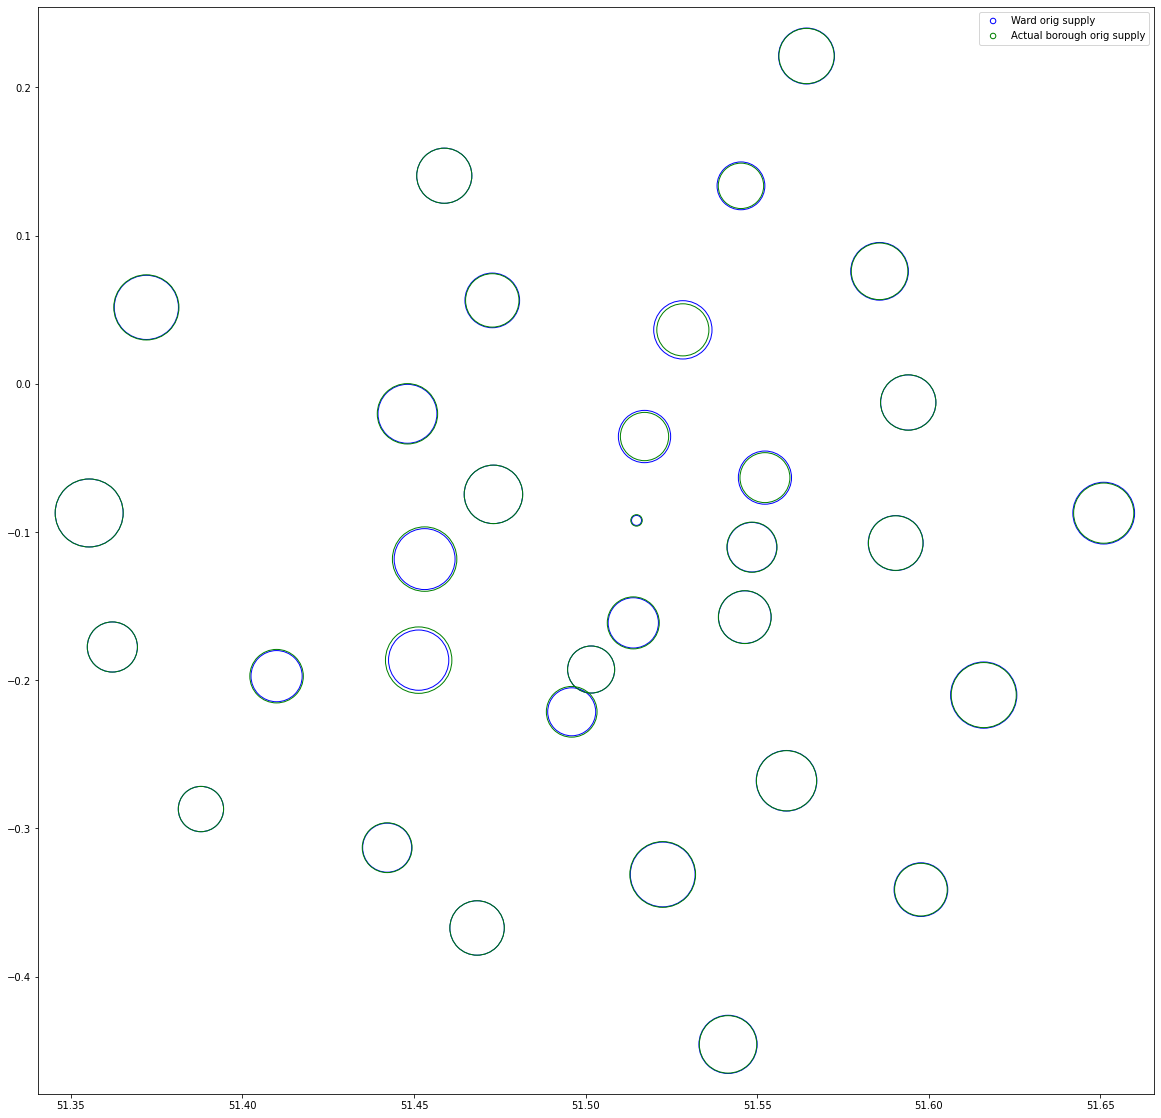

In [88]:
factor = 1e5

plt.figure(figsize=(20,20))
plt.scatter(dest_locs[:, 1], dest_locs[:, 0], facecolor="None",edgecolors='b', s=factor*ow, alpha=1,label='Ward orig supply')
plt.scatter(dest_locs[:, 1], dest_locs[:, 0], facecolor="None",edgecolors='g', s=factor*ob, alpha=1,label='Actual borough orig supply')
# Plot legend.
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]